In [1]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
import os

cwd = os.getcwd()
cwd
benchmark_result_path = os.path.realpath(os.path.join(cwd, "../data/app-results.csv"))
benchmark_result_path

'/Users/csalih/Developer/bsc-web-benchmark/benchmark/benchmark-analyze/data/app-results.csv'

In [3]:
# Load the dataset
csv_headers = ["framework", "metric", "os", "browser", "value"]
df = pd.read_csv(benchmark_result_path, header=None, names=csv_headers)

# Group the data
frameworks = df["framework"].unique()
metrics = df["metric"].unique()
browsers = df["browser"].unique()
operating_systems = df["os"].unique()

df_by_framework = df.groupby("framework")
df_by_metric = df.groupby("metric")

# Display basic info
pd.concat([df.head(5), df.tail(5)])

,framework,metric,os,browser,value
0,app-angular,create_1000_duration,darwin,chromium,56.2
1,app-angular,create_10000_duration,darwin,chromium,558.3
2,app-angular,append_1000_rows_duration,darwin,chromium,60.6
3,app-angular,update_every_10th_row_duration,darwin,chromium,4.6
4,app-angular,swap_rows_duration,darwin,chromium,10.3
17995,app-vue,create_1000_duration,win32,webkit,354.0
17996,app-vue,create_10000_duration,win32,webkit,4881.0
17997,app-vue,append_1000_rows_duration,win32,webkit,361.0
17998,app-vue,update_every_10th_row_duration,win32,webkit,62.0
17999,app-vue,swap_rows_duration,win32,webkit,75.0


In [4]:
# Validate

# Check if there is sufficient data for ANOVA
if (
    df["framework"].nunique() < 0
    or df["browser"].nunique() < 0
    or df["os"].nunique() < 0
):
    raise Exception(f"Metric {metric} has insufficient data.")


# Group by all factors and count the number of observations
counts = (
    df.groupby(["framework", "metric", "browser", "os"])
    .size()
    .reset_index(name="count")
)
single_observations = counts[counts["count"] == 1]

if not single_observations.empty:
    print("WARNING: The following groups have only one observation. ANOVA may fail:")
    print(single_observations)
    raise Exception("Consider combining levels or simplifying your model.")

In [5]:
# Initialize a results dictionary
anova_results = {}

for metric, group_df in df_by_metric:
    # Perform ANOVA for the metric
    model = ols("value ~ C(framework)", data=group_df).fit()
    anova_results[metric] = sm.stats.anova_lm(model, typ=1)

    print("######################################################################")
    print(f"ANOVA Results for Metric: {metric}")
    print("######################################################################")
    print(anova_results[metric])
    print("")

######################################################################
ANOVA Results for Metric: append_1000_rows_duration
######################################################################
                  df        sum_sq        mean_sq          F        PR(>F)
C(framework)     3.0  4.265982e+05  142199.402787  11.764317  1.145948e-07
Residual      3596.0  4.346611e+07   12087.348766        NaN           NaN

######################################################################
ANOVA Results for Metric: create_10000_duration
######################################################################
                  df        sum_sq       mean_sq          F        PR(>F)
C(framework)     3.0  3.179102e+08  1.059701e+08  34.493366  5.678767e-22
Residual      3596.0  1.104758e+10  3.072187e+06        NaN           NaN

######################################################################
ANOVA Results for Metric: create_1000_duration
#################################################

######################################################################
Tukey Results for Metric: append_1000_rows_duration
######################################################################
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1     group2   meandiff p-adj   lower    upper   reject
---------------------------------------------------------------
app-angular app-leptos -13.2873 0.0509 -26.6082   0.0335  False
app-angular  app-react -19.1449 0.0013 -32.4657   -5.824   True
app-angular    app-vue -30.1854    0.0 -43.5063 -16.8646   True
 app-leptos  app-react  -5.8576 0.6708 -19.1784   7.4633  False
 app-leptos    app-vue -16.8981 0.0062  -30.219  -3.5773   True
  app-react    app-vue -11.0406 0.1437 -24.3614   2.2803  False
---------------------------------------------------------------
######################################################################
Tukey Results for Metric: create_10000_duration
###############################################

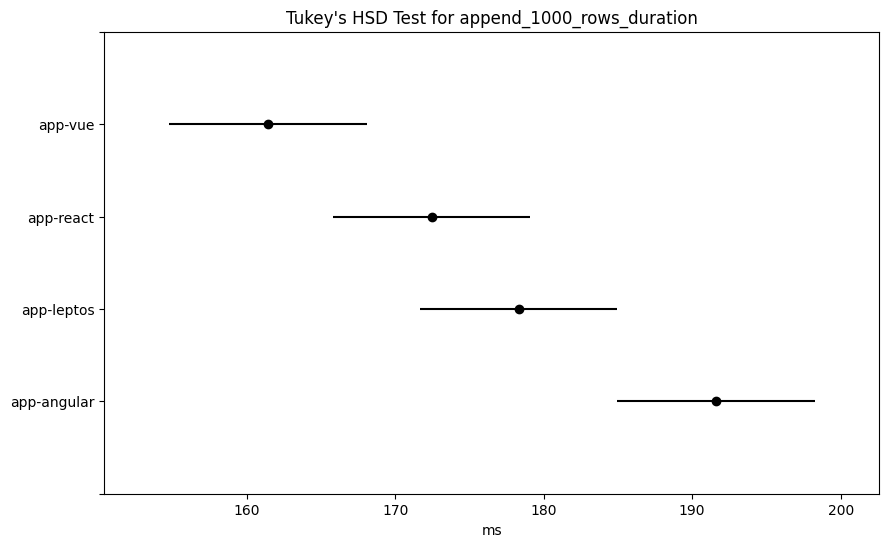

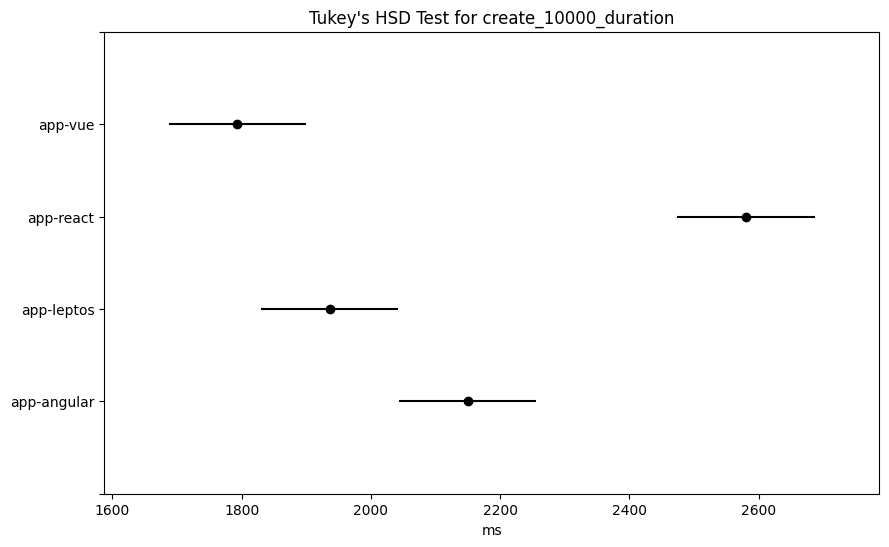

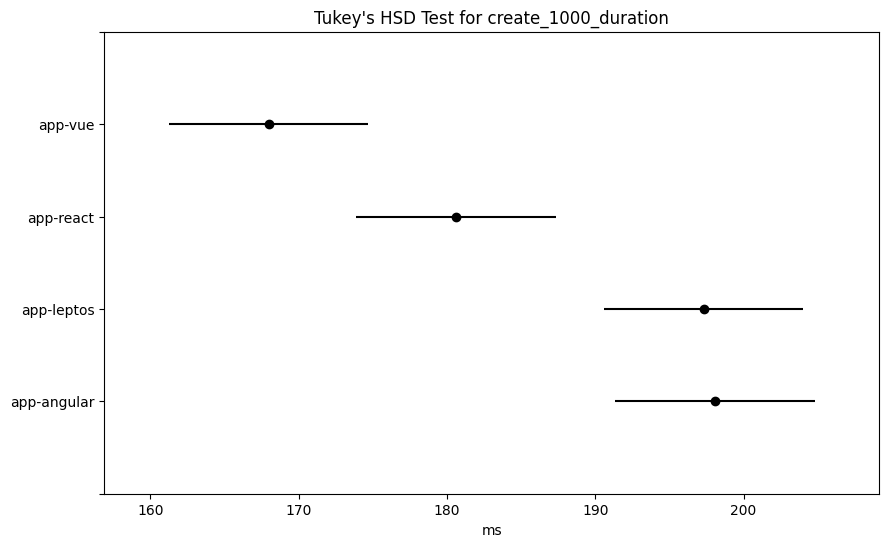

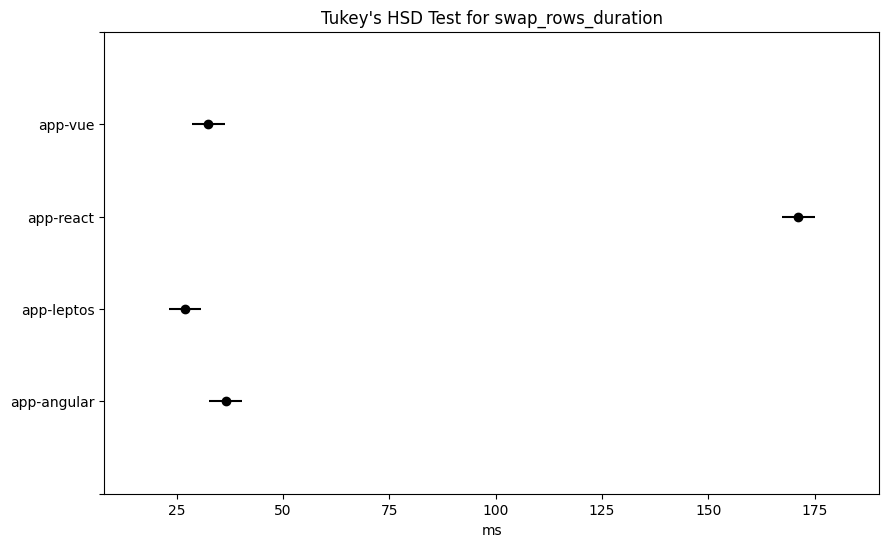

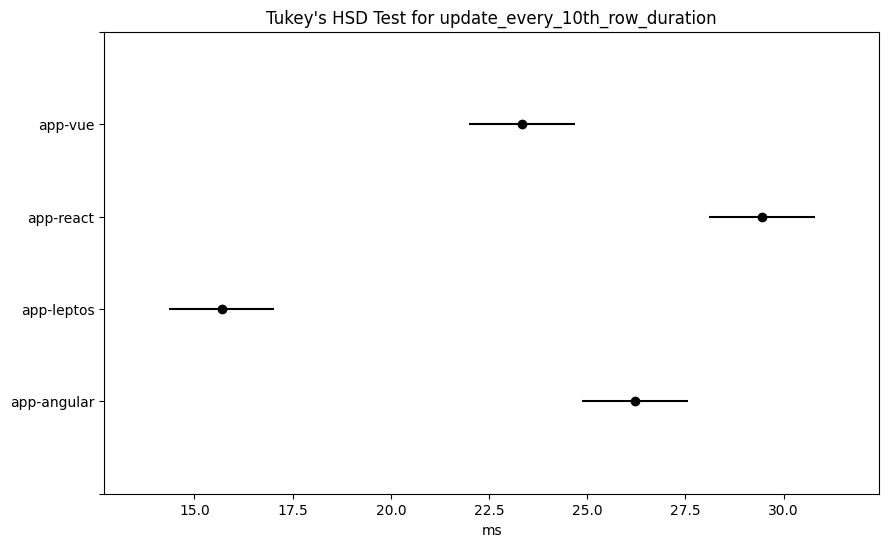

In [6]:
alpha = 0.05

for metric, group_df in df_by_metric:
    endog = group_df["value"]  # Data
    groups = group_df["framework"]  # Groups

    tukey = pairwise_tukeyhsd(endog, groups, alpha)

    print("######################################################################")
    print(f"Tukey Results for Metric: {metric}")
    print("######################################################################")
    print(tukey.summary())

    # Plot group confidence intervals
    fig, ax = plt.subplots(figsize=(1, 1))
    tukey.plot_simultaneous(ax=ax, xlabel="ms")
    # plt.vlines(x=50, ymin=-0.5, ymax=4.5, color="red")

    ax.set_title(f"Tukey's HSD Test for {metric}")

append_1000_rows_duration              Axes(0.1,0.679412;0.363636x0.220588)
create_10000_duration             Axes(0.536364,0.679412;0.363636x0.220588)
create_1000_duration                   Axes(0.1,0.414706;0.363636x0.220588)
swap_rows_duration                Axes(0.536364,0.414706;0.363636x0.220588)
update_every_10th_row_duration             Axes(0.1,0.15;0.363636x0.220588)
dtype: object

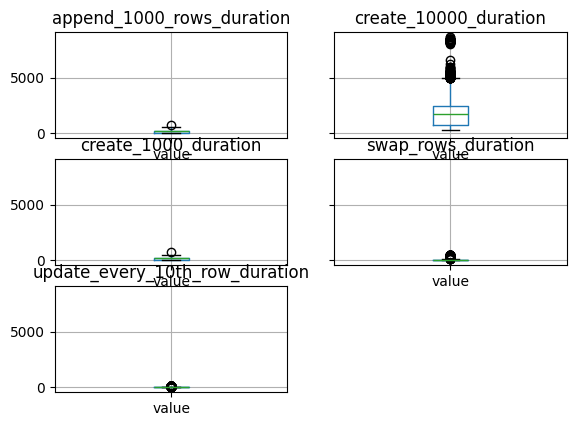

In [11]:
df_by_metric.boxplot()